<a href="https://colab.research.google.com/github/nishvit/DNN/blob/master/Session_7_test_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Conv2D, Input, DepthwiseConv2D, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import layers, models
import pandas as pd
import os
import cv2

from keras.preprocessing.image import img_to_array,array_to_img
from keras.preprocessing import image
from PIL import Image
from IPython.display import display

import tensorflow as K
#mport tensorflow.keras.backend as K
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import warnings

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
(features, labels), (tst_features, tst_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

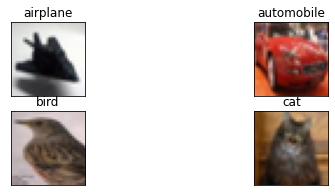

In [3]:
class_names = ['airplane','automobile','bird','cat']
for_heatmap_plot = dict ()
fig = plt.figure(figsize=(8,3))
for i in range(4):
    ax = fig.add_subplot(2, 2, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    im = features_idx[i]
    ax.set_title(class_names[i])
    for_heatmap_plot[ class_names[i] ] = train_features[idx]
    plt.imshow(im)
plt.show()


In [4]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [5]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [6]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)
cardinality = 32


In [7]:
from keras import layers
def create_model ():
  #define global parameters
  img_width = 32
  img_height = 32
  img_channels = 3

  def assignment_7B (x):
  
    def add_common_layers (y):
      y = layers.BatchNormalization ()(y)
      y = layers.Activation ('relu')(y)
      return y
  
    def concat (y):
      y = layers.concatenate (y)
      y = add_common_layers (y)
      return y

    def sep (y, channel_size, kernel_size, history, count):
      y = layers.SeparableConv2D(channel_size, (kernel_size, kernel_size), padding='same', use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(y)
      y = add_common_layers (y)
      #index = 0
      history.append (y)
      count += 1
      return (y, history, count)
  
    def conv (y, channel_size, kernel_size, history, count):
      y = layers.Conv2D (channel_size, (kernel_size, kernel_size), strides = (1, 1), padding = 'same')(y)
      y = add_common_layers (y)
      #index = 0
      history.append (y)
      count += 1
      return (y, history, count)
    
  
    history = []
    count = -1
  
    #part 1
    (x, history, count) = sep (x, 48, 5, history, count)

    #part 2
    (x, history, count) = conv (x, 48, 5, history, count)

    #part 3
    (x, history, count) = conv (x, 48, 5, history, count)

    #part 4
    (x, history, count) = sep (concat ([x, history[0]]), 48, 5, history, count)
  
    #part 5
    x = layers.MaxPooling2D((2, 2))(concat ([x, history[0]]))
    x = add_common_layers (x)
    history.append (x)

    #part 6
    (x, history, count) = sep (x, 48, 3, history, count)

    #part 7
    #(x, history, count) = conv (x, 48, 5, history, count)
    (x, history, count) = conv (x, 48, 5, history, count)

    #part 8
    (x, history, count) = sep (x, 48, 3, history, count)

    #part 9
    (x, history, count) = sep (x, 48, 5, history, count)
  
    #part 10
    x = layers.MaxPooling2D((2, 2))(concat ([x,history[5]]))
    x = add_common_layers (x)
    history.append (x)

    #part 11
    (x, history, count) = conv (x, 48, 5, history, count)

    #part 12
    (x, history, count) = sep (x, 48, 5, history, count)

    #part 13
    (x, history, count) = conv (x, 48, 5, history, count)

    #part 14
    (x, history, count) = sep (x, 48, 5, history, count)
  
    #part 15 
    x = layers.Conv2D (10, (8, 8))(concat ([x, layers.Reshape((8,8,48*16))(history[3]),history[11]]))
    x = add_common_layers (x)
    x = layers.Flatten()(x)
    x = layers.Activation ('softmax')(x)
    history.append (x)
  
  #  for i, element in enumerate (history):
   #   print (i, element.shape)
    return x

  image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
  network_output = assignment_7B (image_tensor)
  
  model = models.Model(inputs=[image_tensor], outputs=[network_output])
  #print(model.summary())
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [8]:
model = [create_model (), create_model ()]
model[0].summary ()
model[1].summary ()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 32, 32, 48)   219         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 48)   192         separable_conv2d[0][0]           
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 48)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

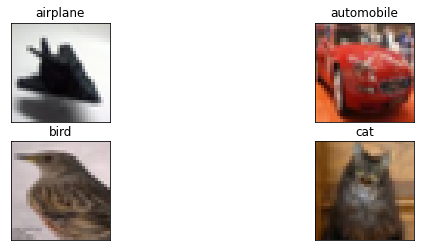

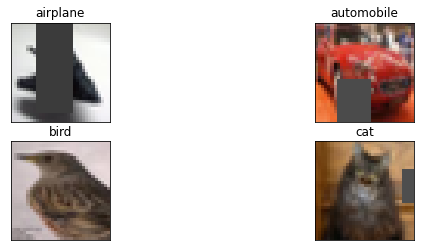

In [10]:
eraser = get_random_eraser()
fig = plt.figure(figsize=(10,4))
for i in range(4):
    ax = fig.add_subplot(2, 2, 1 + i, xticks=[], yticks=[])
    idx = np.where(labels[:]==i)[0]
    features_idx = features[idx,::]
    im = features_idx[i]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

fig = plt.figure(figsize=(10,4))
for i in range(4):
    ax = fig.add_subplot(2, 2, 1 + i, xticks=[], yticks=[])
    idx = np.where(labels[:]==i)[0]
    features_idx = features[idx,::]
    im = features_idx[i]
    ax.set_title(class_names[i])
    plt.imshow(eraser(im))
plt.show()



In [17]:
def heat_map (data, model, model_name):
  
  def generate_heat_map (img, model, name):
    x = img.astype('float32')/255
    preds = model.predict(x)
    with K.GradientTape() as tape:
      class_idx = np.argmax(preds[0])
      class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer(name)
    
    grads = tape.gradient(class_output, last_conv_layer.output)
    #pooled_grads = np.mean(grads, axis=(0, 1, 2))
    iterate = K.keras.models.Model([model.inputs], [model.output, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([x])
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap
  
  h = 5
  w = 5
  fig = plt.figure (figsize = (10, 10))
  columns = 3
  rows = len (data.keys())
  classes = list (data.keys ())
  #print (classes[1])
  for i, classe in enumerate (classes):
    img = data[ classes[i] ][0]
    ax = fig.add_subplot(rows, columns, (i*columns)+3, xticks=[], yticks=[])
    ax.set_title (classes[i])
    plt.imshow(img)
    
    h1 = generate_heat_map (data[ classes[i] ], model, model_name)
    ax = fig.add_subplot(rows, columns, (i*columns)+2, xticks=[], yticks=[])
    ax.set_title ('heatmap')
    plt.imshow(h1)

    heatmap = cv2.resize(h1, (img.shape[0], img.shape[1]))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    ax = fig.add_subplot(rows, columns, (i*columns)+1, xticks=[], yticks=[])
    ax.set_title ('resized heatmap')
    plt.imshow(heatmap)
  plt.show()

************************Model 1***********************


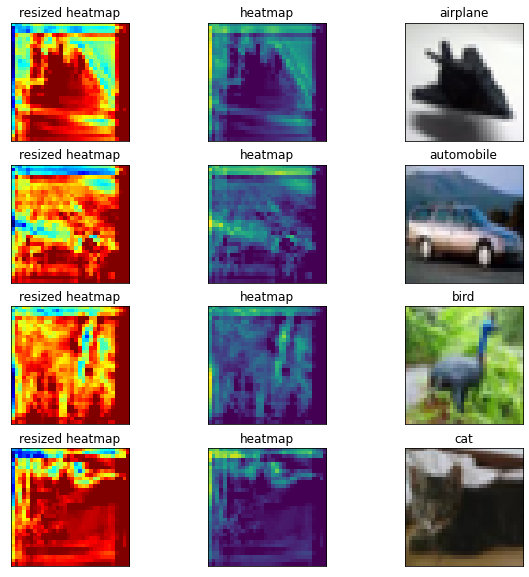

************************Model 2***********************


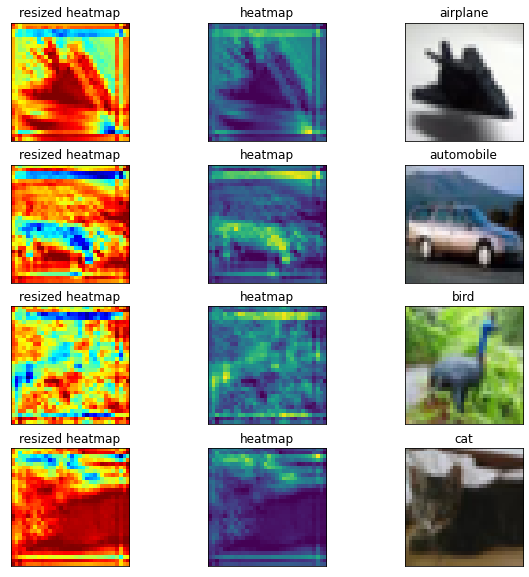

In [12]:
print("************************Model 1***********************")
heat_map (for_heatmap_plot, model[0], 'conv2d_1')
print("************************Model 2***********************")
heat_map (for_heatmap_plot, model[1], 'conv2d_6')

Epoch 1/25
1563/1563 [==============================] - 35s 22ms/step - loss: 1.3444 - accuracy: 0.5641 - val_loss: 1.0939 - val_accuracy: 0.6385
Epoch 2/25
1563/1563 [==============================] - 34s 22ms/step - loss: 0.9273 - accuracy: 0.6983 - val_loss: 0.8812 - val_accuracy: 0.7137
Epoch 3/25
1563/1563 [==============================] - 34s 22ms/step - loss: 0.7444 - accuracy: 0.7578 - val_loss: 0.8088 - val_accuracy: 0.7376
Epoch 4/25
1563/1563 [==============================] - 34s 22ms/step - loss: 0.6044 - accuracy: 0.8022 - val_loss: 0.7347 - val_accuracy: 0.7559
Epoch 5/25
1563/1563 [==============================] - 34s 22ms/step - loss: 0.4861 - accuracy: 0.8443 - val_loss: 0.7144 - val_accuracy: 0.7689
Epoch 6/25
1563/1563 [==============================] - 35s 22ms/step - loss: 0.3893 - accuracy: 0.8763 - val_loss: 0.8305 - val_accuracy: 0.7294
Epoch 7/25
1563/1563 [==============================] - 34s 22ms/step - loss: 0.2983 - accuracy: 0.9076 - val_loss: 0.7948 -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


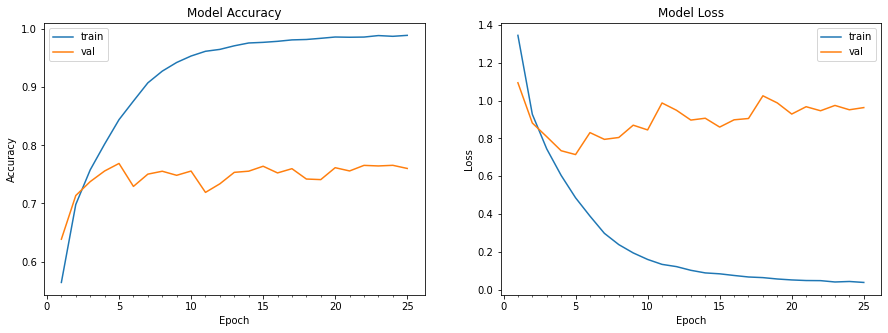

Accuracy on test data is: 76.03


In [13]:

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model[0].fit(datagen.flow(train_features, train_labels, batch_size = 32),
                                 steps_per_epoch = None, epochs = 25, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model[0]))

Epoch 1/25
1563/1563 [==============================] - 35s 23ms/step - loss: 1.4564 - accuracy: 0.5147 - val_loss: 1.2086 - val_accuracy: 0.5882
Epoch 2/25
1563/1563 [==============================] - 35s 22ms/step - loss: 1.0537 - accuracy: 0.6522 - val_loss: 1.0411 - val_accuracy: 0.6437
Epoch 3/25
1563/1563 [==============================] - 35s 23ms/step - loss: 0.8836 - accuracy: 0.7043 - val_loss: 0.8747 - val_accuracy: 0.7077
Epoch 4/25
1563/1563 [==============================] - 35s 22ms/step - loss: 0.7556 - accuracy: 0.7477 - val_loss: 0.7340 - val_accuracy: 0.7535
Epoch 5/25
1563/1563 [==============================] - 35s 22ms/step - loss: 0.6497 - accuracy: 0.7836 - val_loss: 0.7843 - val_accuracy: 0.7480
Epoch 6/25
1563/1563 [==============================] - 35s 22ms/step - loss: 0.5586 - accuracy: 0.8154 - val_loss: 0.8442 - val_accuracy: 0.7302
Epoch 7/25
1563/1563 [==============================] - 35s 22ms/step - loss: 0.4842 - accuracy: 0.8432 - val_loss: 0.7881 -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


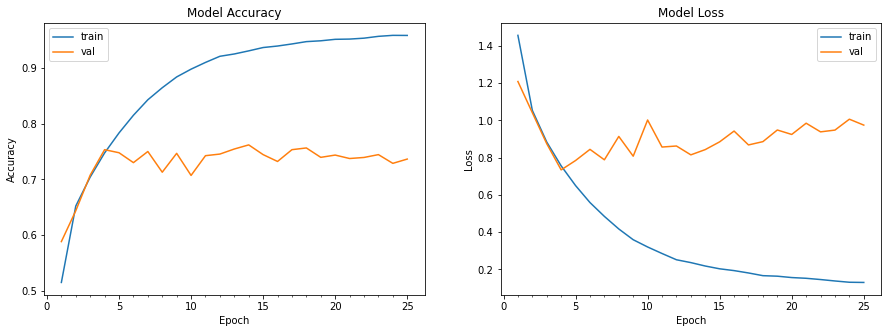

Accuracy on test data is: 73.66


In [14]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1))


# train the model
start = time.time()
# Train the model
model_info = model[1].fit(datagen.flow(train_features, train_labels, batch_size = 32),
                                 steps_per_epoch = None, epochs = 25, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model[1]))

************************Model 1***********************


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


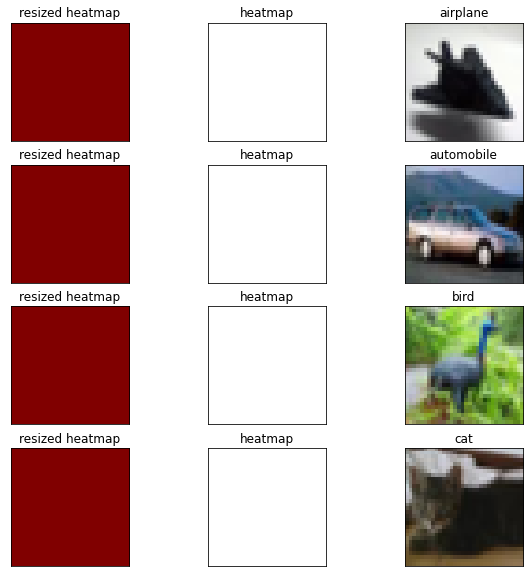

************************Model 2***********************


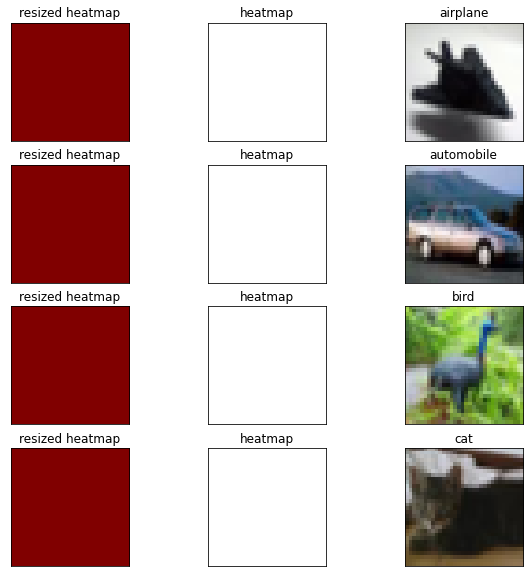

In [18]:
print("************************Model 1***********************")
heat_map (for_heatmap_plot, model[0], 'conv2d_1')
print("************************Model 2***********************")
heat_map (for_heatmap_plot, model[1], 'conv2d_6')